In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naidu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\naidu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# Load the dataset

df = pd.read_csv('..\\Dataset\\flipkart_product.csv', encoding = 'latin1')

In [10]:
df.head()

,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Super!,Great cooler.. excellent air flow and for this...
1,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",5,Awesome,Best budget 2 fit cooler. Nice cooling
2,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room/Personal Air Cooler?ÿ?ÿ(White...,"??3,999",3,Fair,Ok ok product


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189874 entries, 0 to 189873
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ProductName  189874 non-null  object
 1   Price        189873 non-null  object
 2   Rate         189873 non-null  object
 3   Review       189870 non-null  object
 4   Summary      189860 non-null  object
dtypes: object(5)
memory usage: 7.2+ MB


In [13]:
# Convert the 'Rate' column to numeric, handling any non-numeric values
df['Rate'] = pd.to_numeric(df['Rate'], errors='coerce')

# Preprocess rating to sentiment labels
df['sentiment'] = df['Rate'].apply(lambda x: 'positive' if x > 3 else ('neutral' if x == 3 else 'negative'))

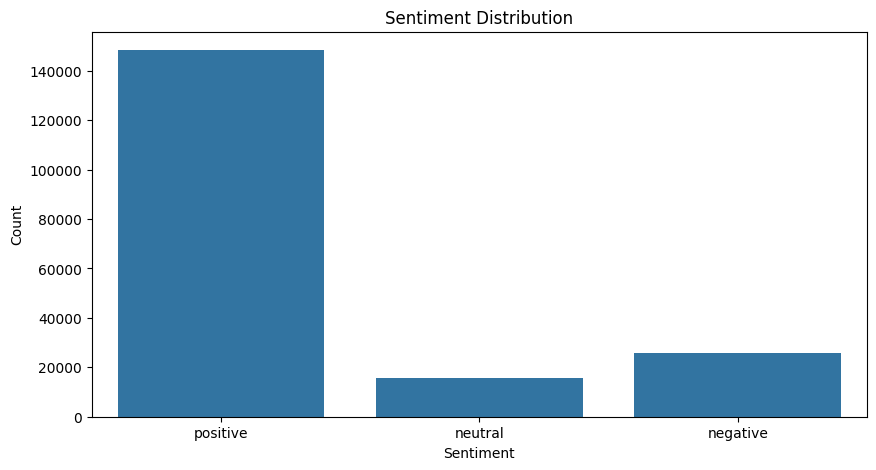

In [15]:
# 1. Sentiment Distribution Plot
plt.figure(figsize=(10,5))
sns.countplot(x='sentiment',data=df, order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [21]:
def generate_wordcloud(sentiment):
    text = ' '.join(df[df['sentiment'] == sentiment]['cleaned_review'])
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{sentiment.capitalize()} Sentiment Word Cloud')
    plt.axis('off')
    plt.show()

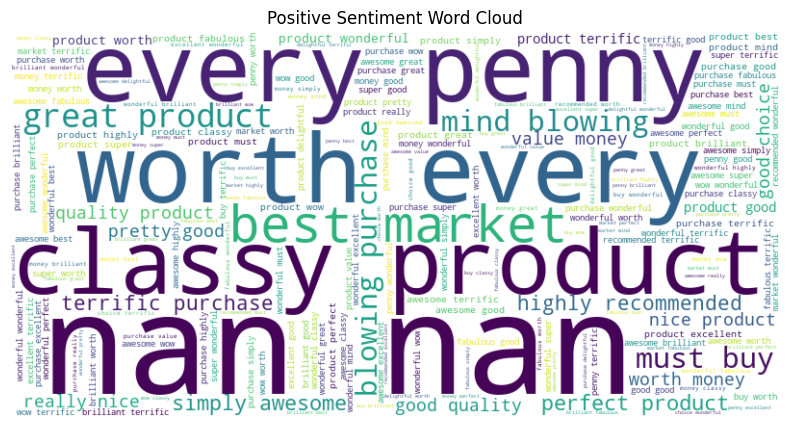

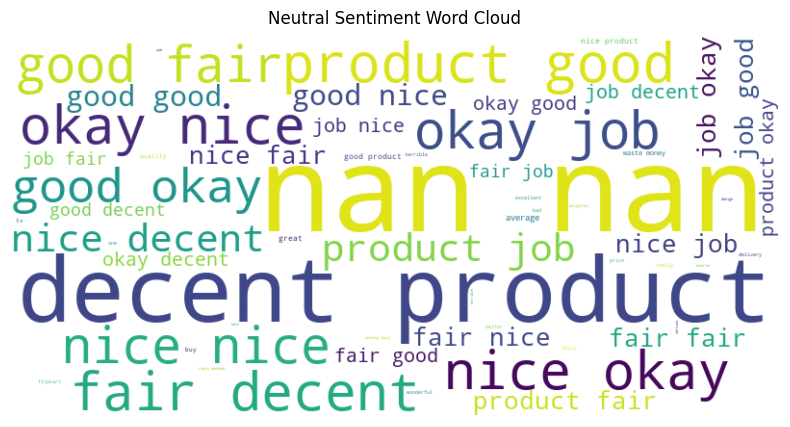

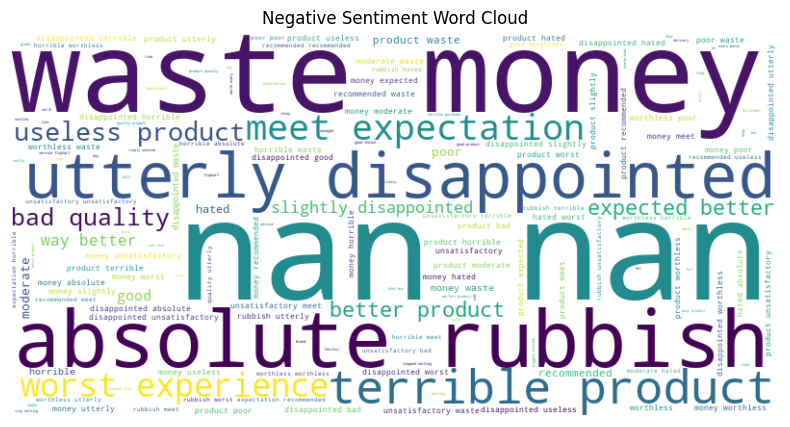

In [25]:
# Preprocess the 'Review' column to create 'cleaned_review'
lemmatizer = WordNetLemmatizer()
df['cleaned_review'] = df['Review'].fillna('').apply(lambda x: ' '.join(
    lemmatizer.lemmatize(word.lower()) for word in re.findall(r'\b\w+\b', str(x)) if word.lower() not in stopwords.words('english')
))

# Generate word clouds for each sentiment
for sentiment in ['positive', 'neutral', 'negative']:
    generate_wordcloud(sentiment)

In [26]:
def plot_top_ngrams(text, n=2, top=20):
    words = text.split()
    ngrams = nltk.ngrams(words, n)
    fdist = FreqDist(ngrams)
    
    plt.figure(figsize=(12,6))
    fdist.plot(top, title=f'Top {top} {n}-grams')
    plt.show()

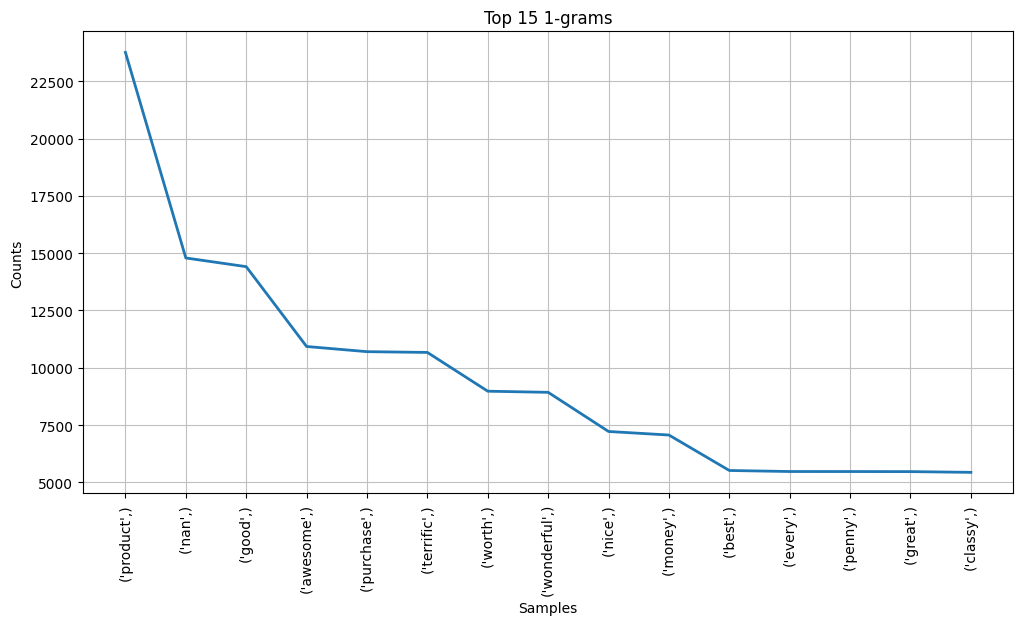

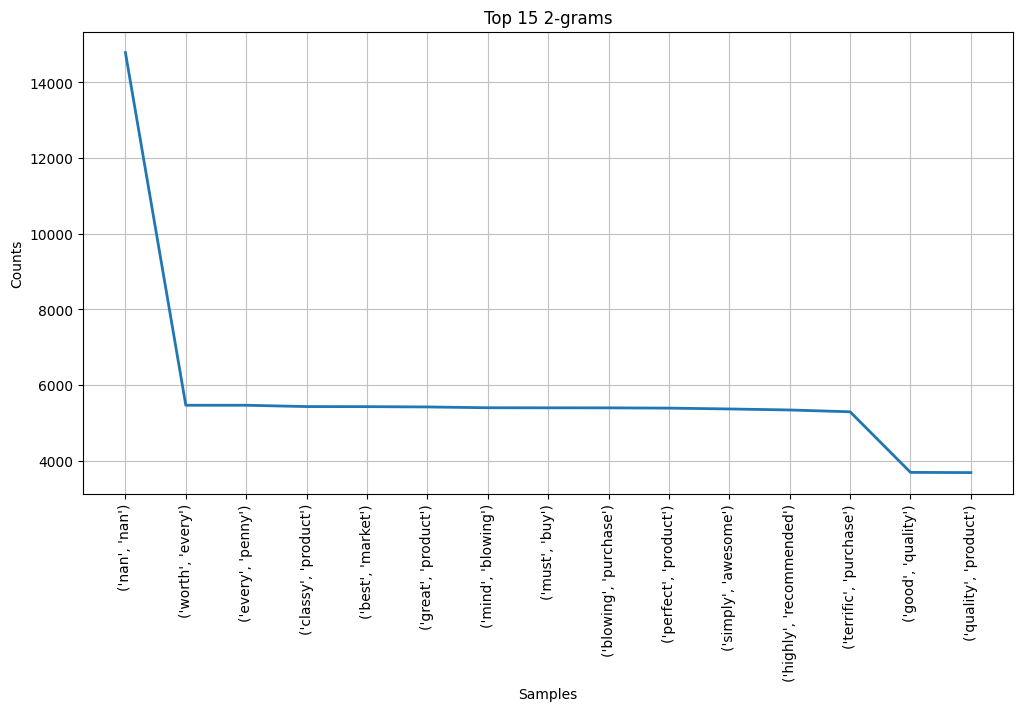

In [27]:
# Plot for positive reviews
positive_text = ' '.join(df[df['sentiment'] == 'positive']['cleaned_review'])
plot_top_ngrams(positive_text, n=1, top=15)  # Unigrams
plot_top_ngrams(positive_text, n=2, top=15)

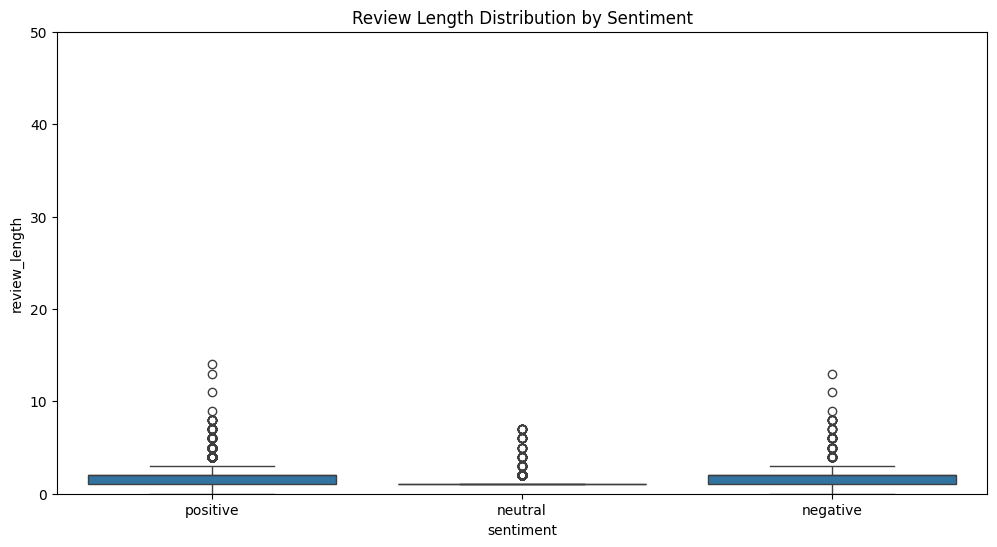

In [28]:
# 4. Review Length Distribution by Sentiment
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
sns.boxplot(x='sentiment', y='review_length', data=df, 
           order=['positive', 'neutral', 'negative'])
plt.title('Review Length Distribution by Sentiment')
plt.ylim(0, 50)  # Adjust based on your data
plt.show()

In [30]:
# Text preprocessing
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [31]:
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    words = text.split()
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [32]:
df['cleaned_review'] = df['Review'].apply(clean_text)

In [33]:
# Split data
X = df['cleaned_review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [35]:
# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [37]:
from sklearn.metrics import classification_report

# Evaluate
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       1.00      0.81      0.90      5135
     neutral       0.99      0.71      0.83      3081
    positive       0.94      1.00      0.97     29759

    accuracy                           0.95     37975
   macro avg       0.98      0.84      0.90     37975
weighted avg       0.95      0.95      0.95     37975



In [39]:
# Save artifacts
joblib.dump(model, 'sentiment_model.pkl')

['sentiment_model.pkl']

In [40]:
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']